**Installing pythainlp**

In [2]:
!pip install pythainlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 46.8 MB/s eta 0:00:00


**Installing Libraries**

In [3]:
import torch, torchdata, torchtext
import torch.nn.functional as F
import torch.nn as nn
from torchtext.data.utils import get_tokenizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
import pythainlp
import random, math, time
from pythainlp import sent_tokenize
from pythainlp import word_tokenize as thai_word_tokenize
from torchtext.vocab import build_vocab_from_iterator
import torch.optim as optim
import time

In [4]:
print(pythainlp.__version__)

4.0.2


In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cpu


**Loading the dataset**

The dataset used is an open data released by  https://airesearch.in.th/releases/
machine-translation-datasets/. It's powered by the incorperation between VISTEC and SCB.

In [7]:
data = pd.read_csv('/content/drive/MyDrive/NLP_A3/data_new.csv')

In [8]:
data['en_text'][:5]

0                Palestine at the 2004 Summer Olympics
1    Palestine competed at the 2004 Summer Olympics...
2                 Pakistan at the 2004 Summer Olympics
3    Pakistan competed at the 2004 Summer Olympics ...
4                Sri Lanka at the 2004 Summer Olympics
Name: en_text, dtype: object

In [9]:
data['th_text'][:5]

0                      ปาเลสไตน์ในโอลิมปิกฤดูร้อน 2004
1    ปาเลสไตน์ในโอลิมปิกฤดูร้อน 2004 ปาเลสไตน์ เข้า...
2                 ประเทศปากีสถานในโอลิมปิกฤดูร้อน 2004
3    ประเทศปากีสถานในโอลิมปิกฤดูร้อน 2004 ประเทศปาก...
4                 ประเทศศรีลังกาในโอลิมปิกฤดูร้อน 2004
Name: th_text, dtype: object

Preparing the data into a list of tuples

In [10]:
# Preparing the data

# Calculate the sizes of the training, validation, and test sets
total_samples = len(data)
train_size = int(total_samples * 0.8)
val_size = test_size = int(total_samples * 0.1)

# Create training set
train = [(data['th_text'][idx], data['en_text'][idx]) for idx in range(0, train_size)]

# Create validation set
val = [(data['th_text'][idx], data['en_text'][idx]) for idx in range(train_size, train_size + val_size)]

# Create test set
test = [(data['th_text'][idx], data['en_text'][idx]) for idx in range(train_size + val_size, total_samples)]

# Print sizes of each set
print("Number of training samples:", len(train))
print("Number of validation samples:", len(val))
print("Number of test samples:", len(test))

Number of training samples: 79
Number of validation samples: 9
Number of test samples: 11


In [11]:
train[:1]

[('ปาเลสไตน์ในโอลิมปิกฤดูร้อน 2004', 'Palestine at the 2004 Summer Olympics')]

In [12]:
val[:1]

[('เหตุการณ์ที่เกิดขึ้นใน ค.ศ. 2002 ในประเทศกรีซ',
  'Events in the year 2002 in Greece.')]

In [13]:
test[:1]

[('ด้านล่างนี้คือ 48 ทีมที่เข้ารอบสำหรับรอบแบ่งกลุ่ม (ค่าสัมประสิทธิ์สโมสรยูฟ่าของพวกเขาในปี 2015), โดยการจัดกลุ่มโถทีมวางของพวกเขา. พวกเขาประกอบด้วย 16ทีมที่เข้ามาในรอบนี้, 22 ทีมผู้ชนะของ รอบเพลย์ออฟ, และ 10 ทีมผู้แพ้ของ แชมเปียนส์ลีก รอบเพลย์ออฟ. Section::::รูปแบบการแข่งขัน.',
  'A total of 44 teams competed in the play-off round to decide 22 of the 48 places in the group stage of the 2015–16 UEFA Europa League. All times were CEST (). Section::::Round and draw dates.')]

**Preprocessing**

1. Tokenizing

The tokenization process is implemented by using the tool called PYThaiNLP which is a Python library for natural language processing (NLP) tasks related to the Thai language. It provides a range of functionalities to work with Thai text, including tokenization, part-of-speech tagging, named entity recognition, and more. The library is designed to assist developers and researchers in building NLP applications that involve the Thai language.

In [14]:
# Checking for thai word tokenizer

thai_word_tokenize('ฉันกำลังทำการบ้านวิชาภาษาอังกฤษ')

['ฉัน', 'กำลัง', 'ทำการบ้าน', 'วิชา', 'ภาษาอังกฤษ']

In [15]:
# Checking for english word tokenizer
word_tokenize('I am doing the english homework')

['I', 'am', 'doing', 'the', 'english', 'homework']

In [16]:
# Place-holders
token_transform = {}
vocab_transform = {}

In [17]:
# Assuming SRC_LANGUAGE is the source language code, and TRG_LANGUAGE is the target language code
SRC_LANGUAGE = 'th'
TRG_LANGUAGE = 'en'

token_transform[SRC_LANGUAGE] = thai_word_tokenize
token_transform[TRG_LANGUAGE] = word_tokenize

In [18]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

In [19]:
def yield_tokens(data, language):
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data:
        yield token_transform[language](data_sample[language_index[language]])

In [20]:
# Assuming you have a dataset like this:
data_sample = [('สวัสดี', 'Hello'), ('สบายดีไหม', 'How are you')]

# Define SRC_LANGUAGE and TRG_LANGUAGE
SRC_LANGUAGE = 'th'
TRG_LANGUAGE = 'en'

# Call the yield_tokens function for the English sentences
for tokenized_sentence in yield_tokens(data_sample, SRC_LANGUAGE):
    print(f"Tokenized English Sentence: {tokenized_sentence}")

# Call the yield_tokens function for the German sentences
for tokenized_sentence in yield_tokens(data_sample, TRG_LANGUAGE):
    print(f"Tokenized Thai Sentence: {tokenized_sentence}")

Tokenized English Sentence: ['สวัสดี']
Tokenized English Sentence: ['สบายดี', 'ไหม']
Tokenized Thai Sentence: ['Hello']
Tokenized Thai Sentence: ['How', 'are', 'you']


**Text to integers (Numericalization)**

In [21]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train, ln),
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end
# Set UNK_IDX as the default index. This index is returned when the token is not found.
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [22]:
#see some example
vocab_transform[SRC_LANGUAGE](['นี่', 'คือ', 'การ','ทดสอบ'])

[0, 389, 11, 0]

In [23]:
#we can reverse it....
mapping = vocab_transform[SRC_LANGUAGE].get_itos()

#print 1816, for example
mapping[12]

'บา'

In [24]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [25]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [26]:
#check unique vocabularies
len(mapping)

538

**Preparing the dataloader**

In [27]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 4

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first = True) #<----need this because we use linear layers mostly
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first = True)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

In [28]:
batch_size = 4

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val,   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test,  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [29]:
for th, length, en in train_loader:
    break

In [30]:
length.shape

torch.Size([4])

In [31]:
print("English shape: ", th.shape)
print("Thai shape: ", en.shape)

English shape:  torch.Size([4, 52])
Thai shape:  torch.Size([4, 30])


**General Attention**

Encoder

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        _src, _ = self.self_attention(src, src, src, src_mask)
        src     = self.self_attn_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]

        _src    = self.feedforward(src)
        src     = self.ff_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]

        return src

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_length = 1000):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                                           for _ in range(n_layers)])
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)

    def forward(self, src, src_mask):

        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = src.shape[0]
        src_len    = src.shape[1]

        pos        = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, src_len]

        src        = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src: [batch_size, src_len, hid_dim]

        for layer in self.layers:
            src = layer(src, src_mask)
        #src: [batch_size, src_len, hid_dim]

        return src


Multihead Attention

In [ ]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads

        self.fc_q     = nn.Linear(hid_dim, hid_dim)
        self.fc_k     = nn.Linear(hid_dim, hid_dim)
        self.fc_v     = nn.Linear(hid_dim, hid_dim)

        self.fc_o     = nn.Linear(hid_dim, hid_dim)

        self.dropout  = nn.Dropout(dropout)

        self.scale    = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask = None):
        #src, src, src, src_mask
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]

        batch_size = query.shape[0]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        #Q=K=V: [batch_size, src len, hid_dim]

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        #Q = [batch_size, n heads, query len, head_dim]

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        #Q = [batch_size, n heads, query len, head_dim] @ K = [batch_size, n heads, head_dim, key len]
        #energy = [batch_size, n heads, query len, key len]

        #for making attention to padding to 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        attention = torch.softmax(energy, dim = -1)
        #attention = [batch_size, n heads, query len, key len]

        x = torch.matmul(self.dropout(attention), V)
        #[batch_size, n heads, query len, key len] @ [batch_size, n heads, value len, head_dim]
        #x = [batch_size, n heads, query len, head dim]

        x = x.permute(0, 2, 1, 3).contiguous()  #we can perform .view
        #x = [batch_size, query len, n heads, head dim]

        x = x.view(batch_size, -1, self.hid_dim)
        #x = [batch_size, query len, hid dim]

        x = self.fc_o(x)
        #x = [batch_size, query len, hid dim]

        return x, attention


Position-wise Feedforward Layer

In [ ]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        #x = [batch size, src len, hid dim]
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

Decoder

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention    = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg     = self.self_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]

        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg             = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        #attention = [batch_size, n heads, trg len, src len]

        _trg = self.feedforward(trg)
        trg  = self.ff_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]

        return trg, attention

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads,
                 pf_dim, dropout, device,max_length = 1000):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                                            for _ in range(n_layers)])
        self.fc_out        = nn.Linear(hid_dim, output_dim)
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = trg.shape[0]
        trg_len    = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, trg len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg: [batch_size, trg len, hid dim]

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        #trg: [batch_size, trg len, hid dim]
        #attention: [batch_size, n heads, trg len, src len]

        output = self.fc_out(trg)
        #output = [batch_size, trg len, output_dim]

        return output, attention

Seq2Seq

In [ ]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):

        #src = [batch size, src len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask

    def make_trg_mask(self, trg):

        #trg = [batch size, trg len]

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]

        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]

        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]

        return trg_mask

    def forward(self, src, trg):

        #src = [batch size, src len]
        #trg = [batch size, trg len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]

        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]

        return output, attention

Training

In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [ ]:
INPUT_DIM = len(vocab_transform[SRC_LANGUAGE])
OUTPUT_DIM = len(vocab_transform[TRG_LANGUAGE])
HID_DIM = 16
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 32
DEC_PF_DIM = 32
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM,
              HID_DIM,
              ENC_LAYERS,
              ENC_HEADS,
              ENC_PF_DIM,
              ENC_DROPOUT,
              device)

dec = Decoder(OUTPUT_DIM,
              HID_DIM,
              DEC_LAYERS,
              DEC_HEADS,
              DEC_PF_DIM,
              DEC_DROPOUT,
              device)

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

In [ ]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
hid_dim = 16
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 32
dec_pf_dim = 32
enc_dropout = 0.1
dec_dropout = 0.1

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

enc = Encoder(input_dim,
              hid_dim,
              enc_layers,
              enc_heads,
              enc_pf_dim,
              enc_dropout,
              device)

dec = Decoder(output_dim,
              hid_dim,
              dec_layers,
              dec_heads,
              dec_pf_dim,
              enc_dropout,
              device)

model_general = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model_general.apply(initialize_weights)

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(538, 16)
    (pos_embedding): Embedding(1000, 16)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=16, out_features=16, bias=True)
          (fc_k): Linear(in_features=16, out_features=16, bias=True)
          (fc_v): Linear(in_features=16, out_features=16, bias=True)
          (fc_o): Linear(in_features=16, out_features=16, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feedforward): PositionwiseFeedforwardLayer(
          (fc1): Linear(in_features=16, out_features=32, bias=True)
          (fc2): Linear(in_features=32, out_features=16, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): 

In [ ]:
lr = 0.0005

#training hyperparameters
optimizer = optim.Adam(model_general.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

In [ ]:
def train(model, loader, optimizer, criterion, clip, loader_length):

    model.train()

    epoch_loss = 0

    for src, src_len, trg in loader:

        src = src.to(device)
        trg = trg.to(device)

        optimizer.zero_grad()

        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])

        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]

        output_dim = output.shape[-1]

        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos

        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / loader_length

In [ ]:
def evaluate(model, loader, criterion, loader_length):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for src, src_len, trg in loader:

            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])

            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / loader_length

In [ ]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
best_valid_loss = float('inf')
num_epochs = 50
clip       = 1

save_path = f'/content/drive/MyDrive/NLP_A3/GeneralAttention.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):

    start_time = time.time()

    train_loss = train(model_general, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model_general, valid_loader, criterion, val_loader_length)

    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)


    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_general.state_dict(), save_path)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

    #lower perplexity is better

Epoch: 01 | Time: 0m 1s
	Train Loss: 5.972 | Train PPL: 392.456
	 Val. Loss: 5.621 |  Val. PPL: 276.126
Epoch: 02 | Time: 0m 3s
	Train Loss: 5.785 | Train PPL: 325.499
	 Val. Loss: 5.415 |  Val. PPL: 224.858
Epoch: 03 | Time: 0m 3s
	Train Loss: 5.658 | Train PPL: 286.642
	 Val. Loss: 5.222 |  Val. PPL: 185.303
Epoch: 04 | Time: 0m 3s
	Train Loss: 5.554 | Train PPL: 258.370
	 Val. Loss: 5.038 |  Val. PPL: 154.141
Epoch: 05 | Time: 0m 3s
	Train Loss: 5.422 | Train PPL: 226.441
	 Val. Loss: 4.849 |  Val. PPL: 127.667
Epoch: 06 | Time: 0m 5s
	Train Loss: 5.332 | Train PPL: 206.845
	 Val. Loss: 4.672 |  Val. PPL: 106.888
Epoch: 07 | Time: 0m 2s
	Train Loss: 5.233 | Train PPL: 187.291
	 Val. Loss: 4.501 |  Val. PPL:  90.140
Epoch: 08 | Time: 0m 1s
	Train Loss: 5.140 | Train PPL: 170.663
	 Val. Loss: 4.344 |  Val. PPL:  76.979
Epoch: 09 | Time: 0m 2s
	Train Loss: 5.044 | Train PPL: 155.128
	 Val. Loss: 4.198 |  Val. PPL:  66.556
Epoch: 10 | Time: 0m 3s
	Train Loss: 4.982 | Train PPL: 145.756


Text(0, 0.5, 'loss')

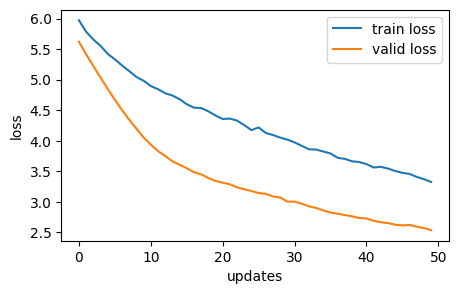

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

**Additive Attention**

Encoder

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)

    def forward(self, src, src_mask):

        # print('===================== start EncoderLayer ==================================== \n ')
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        #print("Input shape (src):", src.shape)

        _src, _ = self.self_attention(src, src, src, src_mask)
        #print("Self-Attention output shape (_src):", _src.shape)

        src = self.self_attn_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]
        #print("Self-Attention Layer Normalization output shape (src):", src.shape)

        _src = self.feedforward(src)
        #print("Feedforward output shape (_src):", _src.shape)

        src = self.ff_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]
        #print("Feedforward Layer Normalization output shape (src):", src.shape)

        # print('===================== End EncoderLayer ==================================== \n ')

        return src


In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_length=1000):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                                     for _ in range(n_layers)])
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)

    def forward(self, src, src_mask):

        # print('===================== start Encoder ==================================== \n ')
        # src = [batch size, src len]
        # src_mask = [batch size, 1, 1, src len]

        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        # pos: [batch_size, src_len]

        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        # src: [batch_size, src_len, hid_dim]
        #print("Input shape (src):", src.shape)

        for layer in self.layers:
            src = layer(src, src_mask)
            #print("Layer output shape (src):", src.shape)
        # src: [batch_size, src_len, hid_dim]

        # print('===================== End Encoder ==================================== \n ')

        return src


MultiheadAttention

In [ ]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads

        self.fc_q     = nn.Linear(hid_dim, hid_dim)
        self.fc_k     = nn.Linear(hid_dim, hid_dim)
        self.fc_v     = nn.Linear(hid_dim, n_heads)

        self.W1 = nn.Linear(hid_dim, hid_dim)
        self.W2 = nn.Linear(hid_dim, hid_dim)

        self.fc_o     = nn.Linear(hid_dim, hid_dim)
        self.fc_attention = nn.Linear(hid_dim,n_heads)

        self.dropout  = nn.Dropout(dropout)

        self.scale    = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask = None):

        # print(f'mask:{mask.shape}')

        #mask shape:[batch_size, 1, 1, query_len]
        #src, src, src, src_mask
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]

        # print(f'mask:{mask.shape}')
        batch_size = query.shape[0]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = value

        #print(f'Q:{Q.shape}')
        #print(f'K:{K.shape}')
        #print(f'V:{V.shape}')

        Q = Q.unsqueeze(2)
        K = K.unsqueeze(1)


        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        # print(f'V:{V.shape}')

        # print(W1(Q).shape)
        # print(W2(K).shape)

        energy = torch.tanh(self.W1(Q) + self.W2(K))


        energy = self.fc_v(energy).squeeze(-1).permute(0,3,1,2)
        # print(f'energy:{energy.shape}')

        if mask is not None:
          energy = energy.masked_fill(mask == 0, -1e10)

        attention = torch.softmax(energy, dim=-1)
        # print(f'attention:{attention.shape}')

        V_transposed = V.transpose(-1, -2)
        # print(f'V_reshaped:{V_transposed.shape}')
        # attention = self.fc_attention(attention).permute(0,3,1,2)
        x = torch.matmul(V_transposed,attention)
        # print(f'x:{x.shape}')
        #[batch_size, n heads, query len, key len] @ [batch_size, n heads, value len, head_dim]
        #x = [batch_size, n heads, query len, head dim]

        x = x.permute(0, 2, 1, 3).contiguous()  #we can perform .view
        #x = [batch_size, query len, n heads, head dim]

        x = x.view(batch_size, -1, self.hid_dim)
        #x = [batch_size, query len, hid dim]

        x = self.fc_o(x)
        #x = [batch_size, query len, hid dim]
        # print(f'x:{x.shape}\n')




        return x,attention

In [ ]:
class MultiHeadAttentionDecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads

        self.fc_q     = nn.Linear(hid_dim, hid_dim)
        self.fc_k     = nn.Linear(hid_dim, hid_dim)
        self.fc_v     = nn.Linear(hid_dim, n_heads)

        self.W1 = nn.Linear(hid_dim, hid_dim)
        self.W2 = nn.Linear(hid_dim, hid_dim)

        self.fc_o     = nn.Linear(hid_dim, hid_dim)
        self.fc_attention = nn.Linear(hid_dim,n_heads)

        self.dropout  = nn.Dropout(dropout)

        self.scale    = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask = None):

        #print(f'mask:{mask.shape}')

        #mask shape:[batch_size, 1, 1, query_len]
        #src, src, src, src_mask
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]

        # print(f'mask:{mask.shape}')
        batch_size = query.shape[0]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = value

        #print(f'Q:{Q.shape}')
        #print(f'K:{K.shape}')
        #print(f'V:{V.shape}')

        Q = Q.unsqueeze(2)
        K = K.unsqueeze(1)


        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        # print(f'V:{V.shape}')

        # print(W1(Q).shape)
        # print(W2(K).shape)

        energy = torch.tanh(self.W1(Q) + self.W2(K))


        energy = self.fc_v(energy).squeeze(-1).permute(0,3,1,2)
        # print(f'energy:{energy.shape}')

        if mask is not None:
          energy = energy.masked_fill(mask == 0, -1e10)

        attention = torch.softmax(energy, dim=-1)
        # print(f'attention:{attention.shape}')

        V_transposed = V.transpose(-1, -2)
        # print(f'V_reshaped:{V_transposed.shape}')
        # attention = self.fc_attention(attention).permute(0,3,1,2)
        x = torch.matmul(V_transposed,attention.permute(0,1,3,2))
        # print(f'x:{x.shape}')
        #[batch_size, n heads, query len, key len] @ [batch_size, n heads, value len, head_dim]
        #x = [batch_size, n heads, query len, head dim]

        x = x.permute(0, 2, 1, 3).contiguous()  #we can perform .view
        #x = [batch_size, query len, n heads, head dim]

        x = x.view(batch_size, -1, self.hid_dim)
        #x = [batch_size, query len, hid dim]

        x = self.fc_o(x)
        #x = [batch_size, query len, hid dim]
        # print(f'x:{x.shape}\n')




        return x,attention

In [ ]:
# # Set device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Define the input dimensions
# batch_size = 8
# query_len = 10
# key_len = 12
# hid_dim = 64
# n_heads = 8
# dropout = 0.1

# # Create an instance of MultiHeadAttentionLayer
# attention_layer = MultiHeadAttentionDecoderLayer(hid_dim, n_heads, dropout, device)

# # Generate dummy inputs
# query = torch.randn(batch_size, query_len, hid_dim).to(device)
# key = torch.randn(batch_size, key_len, hid_dim).to(device)
# value = torch.randn(batch_size, key_len, hid_dim).to(device)

# attention_layer(query, key, value)

In [60]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        #print('===================== Start PositionwiseFeedforwardLayer ==================================== \n ')
        # x = [batch size, src len, hid dim]
        #print("Input shape (x):", x.shape)

        x = self.dropout(torch.relu(self.fc1(x)))
       # print("Output shape after fc1 and ReLU:", x.shape)

        x = self.fc2(x)
        #print("Output shape after fc2:", x.shape)

       # print('===================== End PositionwiseFeedforwardLayer ==================================== \n ')

        return x

Decoder

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionDecoderLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionDecoderLayer(hid_dim, n_heads, dropout, device)
        self.feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        # print('===================== Start DecoderLayer ==================================== \n ')

       ##print(f'trg:{trg.shape}')
       # print(f'enc_src:{enc_src.shape}')
       # print(f'trg_mask:{trg_mask.shape}')
       # print(f'src_mask:{src_mask.shape}')
        # trg = [batch size, trg len, hid dim]
        # enc_src = [batch size, src len, hid dim]
        # trg_mask = [batch size, 1, trg len, trg len]
        # src_mask = [batch size, 1, 1, src len]

        #print('self attetion***************')
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
        # trg = [batch_size, trg len, hid dim]
       # print("Self-Attention output shape (trg):", trg.shape)

        #print('encoder_attention***************')
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        # trg = [batch_size, trg len, hid dim]
        # attention = [batch_size, n heads, trg len, src len]
        #print("Encoder Attention output shape (trg):", trg.shape)
        #print("Attention shape:", attention.shape)

        _trg = self.feedforward(trg)
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        # trg = [batch_size, trg len, hid dim]
        #print("Feedforward output shape (trg):", trg.shape)

        # print('===================== End DecoderLayer ==================================== \n ')

        return trg, attention


In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_length=1000):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                                     for _ in range(n_layers)])
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        self.max_len = max_length

    def forward(self, trg, enc_src, trg_mask, src_mask):

        # print('===================== Start Decoder ==================================== \n ')

        #print(f'trg:{trg.shape}')
        #print(f'enc_src:{enc_src.shape}')
        #print(f'trg_mask:{trg_mask.shape}')
        #print(f'src_mask:{src_mask.shape}')
        # trg = [batch size, trg len]
        # enc_src = [batch size, src len, hid dim]
        # trg_mask = [batch size, 1, trg len, trg len]
        # src_mask = [batch size, 1, 1, src len]

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        # pos: [batch_size, trg len]

        assert (pos < self.max_len).all(), "Positional index exceeds maximum length"

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        # trg: [batch_size, trg len, hid dim]
        #print("Input shape (trg):", trg.shape)

        for layer in self.layers:
            #print(f'enc_src{enc_src.shape}')
            #print(f'trg{trg.shape}')
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

            #print("Layer output shape (trg):", trg.shape)
            #print("Attention shape:", attention.shape)

        # trg: [batch_size, trg len, hid dim]
        # attention: [batch_size, n heads, trg len, src len]

        output = self.fc_out(trg)
        # output = [batch_size, trg len, output_dim]
       # print("Output shape:", output.shape)

        # print('===================== End Decoder ==================================== \n ')

        return output, attention

Seq2Seq

In [ ]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):

        # src = [batch size, src len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # src_mask = [batch size, 1, 1, src len]

        return src_mask

    def make_trg_mask(self, trg):

        # trg = [batch size, trg len]

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        # trg_pad_mask = [batch size, 1, 1, trg len]

        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=self.device)).bool()
        # trg_sub_mask = [trg len, trg len]

        trg_mask = trg_pad_mask & trg_sub_mask
        # trg_mask = [batch size, 1, trg len, trg len]

        return trg_mask

    def forward(self, src, trg):

        # print('===================== Start Seq2SeqTransformer ==================================== \n ')

       # print(f'src:{src.shape}')
       # print(f'trg:{trg.shape}')

        # src = [batch size, src len]
        # trg = [batch size, trg len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        # src_mask = [batch size, 1, 1, src len]
        # trg_mask = [batch size, 1, trg len, trg len]

        enc_src = self.encoder(src, src_mask)
        # enc_src = [batch size, src len, hid dim]
       # print("Encoder output shape (enc_src):", enc_src.shape)

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        # output = [batch size, trg len, output dim]
        # attention = [batch size, n heads, trg len, src len]
        #print("Decoder output shape (output):", output.shape)
        #print("Attention shape:", attention.shape)

        # print('===================== End Seq2SeqTransformer ==================================== \n ')
        return output, attention


Training

In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [ ]:
INPUT_DIM = len(vocab_transform[SRC_LANGUAGE])
OUTPUT_DIM = len(vocab_transform[TRG_LANGUAGE])
HID_DIM = 16
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 32
DEC_PF_DIM = 32
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM,
              HID_DIM,
              ENC_LAYERS,
              ENC_HEADS,
              ENC_PF_DIM,
              ENC_DROPOUT,
              device)

dec = Decoder(OUTPUT_DIM,
              HID_DIM,
              DEC_LAYERS,
              DEC_HEADS,
              DEC_PF_DIM,
              DEC_DROPOUT,
              device)

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

In [ ]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
hid_dim = 16
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 32
dec_pf_dim = 32
enc_dropout = 0.1
dec_dropout = 0.1

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

enc = Encoder(input_dim,
              hid_dim,
              enc_layers,
              enc_heads,
              enc_pf_dim,
              enc_dropout,
              device)

dec = Decoder(output_dim,
              hid_dim,
              dec_layers,
              dec_heads,
              dec_pf_dim,
              enc_dropout,
              device)

model_additive = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model_additive.apply(initialize_weights)

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(538, 16)
    (pos_embedding): Embedding(1000, 16)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=16, out_features=16, bias=True)
          (fc_k): Linear(in_features=16, out_features=16, bias=True)
          (fc_v): Linear(in_features=16, out_features=8, bias=True)
          (W1): Linear(in_features=16, out_features=16, bias=True)
          (W2): Linear(in_features=16, out_features=16, bias=True)
          (fc_o): Linear(in_features=16, out_features=16, bias=True)
          (fc_attention): Linear(in_features=16, out_features=8, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feedforward): PositionwiseFeedforwardLayer(
       

In [ ]:
lr = 0.0005

#training hyperparameters
optimizer = optim.Adam(model_additive.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

In [ ]:
def train(model, loader, optimizer, criterion, clip, loader_length):

    model.train()

    epoch_loss = 0

    for src, src_len, trg in loader:

        src = src.to(device)
        trg = trg.to(device)

        optimizer.zero_grad()

        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])

        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]

        output_dim = output.shape[-1]

        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos

        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / loader_length

In [ ]:
def evaluate(model, loader, criterion, loader_length):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for src, src_len, trg in loader:

            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])

            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / loader_length

In [ ]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
best_valid_loss = float('inf')
num_epochs = 50
clip       = 1

save_path = f'/content/drive/MyDrive/NLP_A3/AdditiveAttention.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):

    start_time = time.time()

    train_loss = train(model_additive, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model_additive, valid_loader, criterion, val_loader_length)

    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)


    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_additive.state_dict(), save_path)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

    #lower perplexity is better

Epoch: 01 | Time: 0m 3s
	Train Loss: 6.141 | Train PPL: 464.678
	 Val. Loss: 6.073 |  Val. PPL: 433.935
Epoch: 02 | Time: 0m 2s
	Train Loss: 6.030 | Train PPL: 415.606
	 Val. Loss: 5.893 |  Val. PPL: 362.553
Epoch: 03 | Time: 0m 3s
	Train Loss: 5.928 | Train PPL: 375.269
	 Val. Loss: 5.709 |  Val. PPL: 301.427
Epoch: 04 | Time: 0m 2s
	Train Loss: 5.810 | Train PPL: 333.564
	 Val. Loss: 5.512 |  Val. PPL: 247.617
Epoch: 05 | Time: 0m 3s
	Train Loss: 5.685 | Train PPL: 294.497
	 Val. Loss: 5.298 |  Val. PPL: 200.026
Epoch: 06 | Time: 0m 2s
	Train Loss: 5.552 | Train PPL: 257.743
	 Val. Loss: 5.090 |  Val. PPL: 162.367
Epoch: 07 | Time: 0m 2s
	Train Loss: 5.451 | Train PPL: 232.996
	 Val. Loss: 4.882 |  Val. PPL: 131.928
Epoch: 08 | Time: 0m 2s
	Train Loss: 5.317 | Train PPL: 203.801
	 Val. Loss: 4.694 |  Val. PPL: 109.265
Epoch: 09 | Time: 0m 3s
	Train Loss: 5.240 | Train PPL: 188.594
	 Val. Loss: 4.505 |  Val. PPL:  90.455
Epoch: 10 | Time: 0m 2s
	Train Loss: 5.126 | Train PPL: 168.321


Text(0, 0.5, 'loss')

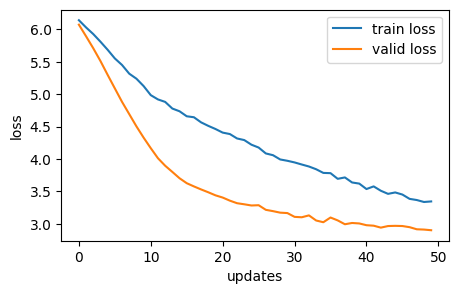

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

**Multiplicative Attention**

Encoder

In [50]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiplicativeAttentionLayer(hid_dim, n_heads, dropout, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        _src, _ = self.self_attention(src, src, src, src_mask)
        src     = self.self_attn_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]

        _src    = self.feedforward(src)
        src     = self.ff_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]

        return src

In [51]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_length = 1000):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                                           for _ in range(n_layers)])
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)

    def forward(self, src, src_mask):

        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = src.shape[0]
        src_len    = src.shape[1]

        pos        = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, src_len]

        src        = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src: [batch_size, src_len, hid_dim]

        for layer in self.layers:
            src = layer(src, src_mask)
        #src: [batch_size, src_len, hid_dim]

        return src

Decoder

In [52]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiplicativeAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention    = MultiplicativeAttentionLayer(hid_dim, n_heads, dropout, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg     = self.self_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]

        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg             = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        #attention = [batch_size, n heads, trg len, src len]

        _trg = self.feedforward(trg)
        trg  = self.ff_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]

        return trg, attention

In [53]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads,
                 pf_dim, dropout, device,max_length = 1000):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                                            for _ in range(n_layers)])
        self.fc_out        = nn.Linear(hid_dim, output_dim)
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = trg.shape[0]
        trg_len    = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, trg len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg: [batch_size, trg len, hid dim]

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        #trg: [batch_size, trg len, hid dim]
        #attention: [batch_size, n heads, trg len, src len]

        output = self.fc_out(trg)
        #output = [batch_size, trg len, output_dim]

        return output, attention

In [54]:
class MultiplicativeAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads
        self.W = nn.Linear(hid_dim,hid_dim)
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)

        self.fc_input = nn.Linear(hid_dim, hid_dim)
        self.fc_o     = nn.Linear(hid_dim, hid_dim)

        self.fc_multiplicative = nn.Linear(hid_dim, hid_dim)


        self.dropout  = nn.Dropout(dropout)



    def forward(self, query, key, value, mask=None):
        batch_size = query.shape[0]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        Q = self.fc_multiplicative(Q)

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2))

        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        attention = torch.softmax(energy, dim = -1)

        x = torch.matmul(self.dropout(attention), V)


        x = x.permute(0, 2, 1, 3).contiguous()


        x = x.view(batch_size, -1, self.hid_dim)


        x = self.fc_o(x)


        return x, attention

SeqToSeq

In [55]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):

        #src = [batch size, src len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask

    def make_trg_mask(self, trg):

        #trg = [batch size, trg len]

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]

        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]

        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]

        return trg_mask

    def forward(self, src, trg):

        #src = [batch size, src len]
        #trg = [batch size, trg len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]

        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]

        return output, attention

Training

In [56]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [61]:
INPUT_DIM = len(vocab_transform[SRC_LANGUAGE])
OUTPUT_DIM = len(vocab_transform[TRG_LANGUAGE])
HID_DIM = 16
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 32
DEC_PF_DIM = 32
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM,
              HID_DIM,
              ENC_LAYERS,
              ENC_HEADS,
              ENC_PF_DIM,
              ENC_DROPOUT,
              device)

dec = Decoder(OUTPUT_DIM,
              HID_DIM,
              DEC_LAYERS,
              DEC_HEADS,
              DEC_PF_DIM,
              DEC_DROPOUT,
              device)

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

In [62]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
hid_dim = 16
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 32
dec_pf_dim = 32
enc_dropout = 0.1
dec_dropout = 0.1

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

enc = Encoder(input_dim,
              hid_dim,
              enc_layers,
              enc_heads,
              enc_pf_dim,
              enc_dropout,
              device)

dec = Decoder(output_dim,
              hid_dim,
              dec_layers,
              dec_heads,
              dec_pf_dim,
              enc_dropout,
              device)

model_multiplicative = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model_multiplicative.apply(initialize_weights)

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(538, 16)
    (pos_embedding): Embedding(1000, 16)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiplicativeAttentionLayer(
          (W): Linear(in_features=16, out_features=16, bias=True)
          (fc_q): Linear(in_features=16, out_features=16, bias=True)
          (fc_k): Linear(in_features=16, out_features=16, bias=True)
          (fc_v): Linear(in_features=16, out_features=16, bias=True)
          (fc_input): Linear(in_features=16, out_features=16, bias=True)
          (fc_o): Linear(in_features=16, out_features=16, bias=True)
          (fc_multiplicative): Linear(in_features=16, out_features=16, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feedforward): PositionwiseFeedforw

In [59]:
lr = 0.0005

#training hyperparameters
optimizer = optim.Adam(model_multiplicative.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

NameError: name 'model_multiplicative' is not defined

In [ ]:
best_valid_loss = float('inf')
num_epochs = 50
clip       = 1

save_path = f'/content/drive/MyDrive/NLP_A3/MultiplicativeAttention.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):

    start_time = time.time()

    train_loss = train(model_multiplicative, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model_multiplicative, valid_loader, criterion, val_loader_length)

    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)


    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_multiplicative.state_dict(), save_path)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

    #lower perplexity is better

Epoch: 01 | Time: 0m 1s
	Train Loss: 5.990 | Train PPL: 399.277
	 Val. Loss: 5.636 |  Val. PPL: 280.362
Epoch: 02 | Time: 0m 1s
	Train Loss: 5.862 | Train PPL: 351.574
	 Val. Loss: 5.456 |  Val. PPL: 234.108
Epoch: 03 | Time: 0m 1s
	Train Loss: 5.721 | Train PPL: 305.074
	 Val. Loss: 5.288 |  Val. PPL: 197.947
Epoch: 04 | Time: 0m 1s
	Train Loss: 5.633 | Train PPL: 279.550
	 Val. Loss: 5.110 |  Val. PPL: 165.750
Epoch: 05 | Time: 0m 2s
	Train Loss: 5.516 | Train PPL: 248.584
	 Val. Loss: 4.928 |  Val. PPL: 138.034
Epoch: 06 | Time: 0m 2s
	Train Loss: 5.383 | Train PPL: 217.584
	 Val. Loss: 4.744 |  Val. PPL: 114.848
Epoch: 07 | Time: 0m 1s
	Train Loss: 5.276 | Train PPL: 195.610
	 Val. Loss: 4.568 |  Val. PPL:  96.376
Epoch: 08 | Time: 0m 1s
	Train Loss: 5.191 | Train PPL: 179.702
	 Val. Loss: 4.403 |  Val. PPL:  81.682
Epoch: 09 | Time: 0m 1s
	Train Loss: 5.091 | Train PPL: 162.606
	 Val. Loss: 4.235 |  Val. PPL:  69.049
Epoch: 10 | Time: 0m 1s
	Train Loss: 4.991 | Train PPL: 147.116


Text(0, 0.5, 'loss')

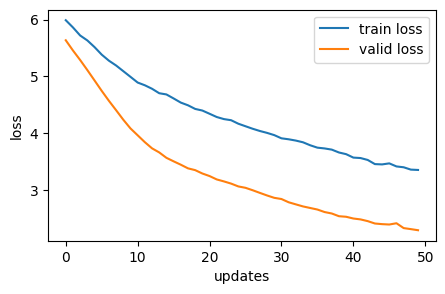

In [ ]:
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

**Summary**

In [ ]:
import pandas as pd

data = {
    'Model': ['Multiplicative', 'Additive', 'General'],
    'Train Loss': [2.422, 2.411, 1.995],
    'Train PPL': [11.264, 11.149, 7.351],
    'Val. Loss': [1.882, 1.821, 1.477],
    'Val. PPL': [6.565, 6.180, 4.378]
}

df = pd.DataFrame(data)

df

,Model,Train Loss,Train PPL,Val. Loss,Val. PPL
0,Multiplicative,2.422,11.264,1.882,6.565
1,Additive,2.411,11.149,1.821,6.180
2,General,1.995,7.351,1.477,4.378


**Testing**

In [ ]:
# Initializing a random sentence

en_sentence = 'I want to go shopping'

In [ ]:
def inference(model, src_sentence, src_tokenizer, trg_tokenizer, sos_idx=1, eos_idx=2):
    model.eval()

    SRC_LANGUAGE = 'th'
    TRG_LANGUAGE = 'en'
    max_len = 100

    # Source Language
    src_tokens = src_tokenizer(src_sentence)
    src = vocab_transform[SRC_LANGUAGE](src_tokens)
    src = torch.tensor([src]).to(device)

    with torch.no_grad():
        # Initialize the trg tensor with sos token
        trg = torch.tensor([[sos_idx]]).to(device)

        output, _ = model(src, trg)

        pred_token = output.argmax(2)[:,-1].item()

        trg = torch.cat((trg, torch.tensor([[pred_token]]).to(device)), dim=1)


    # Convert the predicted tensor to a list of tokens using trg_tokenizer
    predicted_sentence = [vocab_transform[TRG_LANGUAGE].get_itos()[token] for token in trg.squeeze().tolist() if token not in [sos_idx, eos_idx]]

    output = ''.join(predicted_sentence)
    return output

In [ ]:
# Example usage
src_sentence = "ไทย"
predicted_output = inference(model_general, src_sentence, thai_word_tokenize, word_tokenize,  SOS_IDX, EOS_IDX)
print("Input:", src_sentence)
print("Predicted Output:", predicted_output)

Input: ไทย
Predicted Output: 'sforcesofofofofChearmyofofthearmyofofofofofofofofChearmyofChearmyofofofofofofofofoftheCubanarmyandtotheCubanarmyandOctoberbeentototheCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanarmyandtheCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanarmyandtoandandandtheCubanCubanCubanCubanCubanCubanCuban'sarmyandtheCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanarmyandtotheCubanCubanarmyandandtotowriterJohnjustJohnDecemberoftheCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCuban'sarmyand<unk><unk><unk><unk><unk><unk><unk><unk><unk>andtototoandtoandtotheCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCubanCuban'sforcestoa

**Save Necessary variables**

In [ ]:
import pickle

path = '/content/drive/MyDrive/NLP_A3/vocab_transform.pickle'

with open(path,'wb') as f:
  pickle.dump(vocab_transform,f)

**Attention Visualization**

In [32]:
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention):

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    attention = attention.squeeze(1).cpu().detach().numpy()

    cax = ax.matshow(attention, cmap='bone')

    ax.tick_params(labelsize=10)

    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence

    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [41]:
src_tokens = 'ปาเลสไตน์ในโอลิมปิกฤดูร้อน 2004'

trg_tokens = 'Palestine at the 2004 Summer Olympics'

In [42]:
src_text = text_transform[SRC_LANGUAGE](src_tokens).to(device)
src_text

tensor([  2, 286,   5,  90,  89,   4,  81,   3])

In [43]:
trg_tokens

'Palestine at the 2004 Summer Olympics'

In [44]:
trg_text = text_transform[TRG_LANGUAGE](trg_tokens).to(device)
trg_text

tensor([  2, 295,  26,   4,  46,  73,  71,   3])

In [45]:
src_text = src_text.reshape(1, -1)

In [46]:
trg_text = trg_text.reshape(1, -1)

In [47]:
src_text.shape, trg_text.shape

(torch.Size([1, 8]), torch.Size([1, 8]))

In [48]:
text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)

In [63]:
model_multiplicative.load_state_dict(torch.load('/content/drive/MyDrive/NLP_A3/MultiplicativeAttention.pt'))

model_multiplicative.eval()
with torch.no_grad():
    output, attentions = model_multiplicative(src_text, trg_text)

In [64]:
output.shape

torch.Size([1, 8, 439])

In [65]:
attention = attentions[0, 0, :, :]

<ipython-input-32-b23710e830bc>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
<ipython-input-32-b23710e830bc>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3611 (\N{THAI CHARACTER PO PLA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3634 (\N{THAI CHARACTER SARA AA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3648 (\N{THAI CHARACTER SARA E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3621 (\N{THAI CHARACTER LO LING}) 

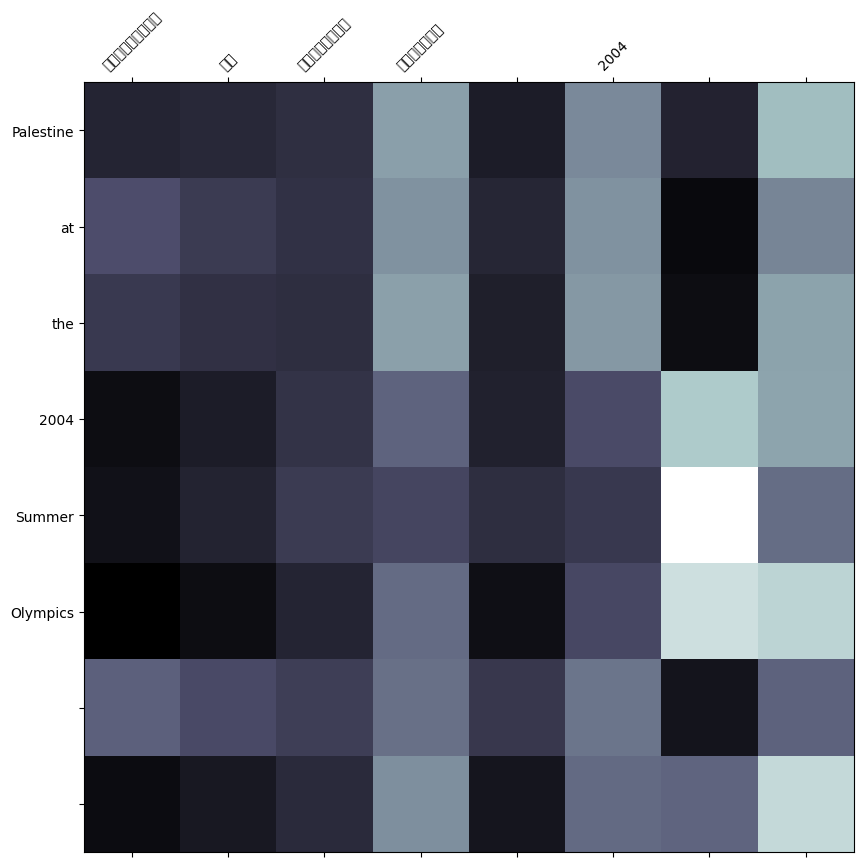

In [66]:
src_tokens = thai_word_tokenize('ปาเลสไตน์ในโอลิมปิกฤดูร้อน 2004')

trg_tokens = word_tokenize('Palestine at the 2004 Summer Olympics')
display_attention(src_tokens, trg_tokens, attention)

**Analysis and Discuss**

1. General Attention

- Training Loss and Perplexity (PPL):

The training loss and perplexity gradually decrease over the epochs, indicating that the model is learning and improving its performance on the training data.
This decrease suggests that the model is becoming more confident in its predictions and is better fitting the training data.
Validation Loss and Perplexity:

Similarly, the validation loss and perplexity also decrease as training progresses.
This indicates that the model is not overfitting to the training data, as the performance on the validation set is also improving.
The decreasing validation loss and perplexity imply that the model is generalizing well to unseen data.


- Comparison of Loss and Perplexity:

Both training and validation loss/perplexity follow a similar trend, indicating that the model is not suffering from overfitting.
The gap between training and validation loss/perplexity is relatively consistent, suggesting that there is no significant overfitting or underfitting issue.



- Training Time:

The time taken for each epoch seems reasonable, with a consistent duration across epochs.
This suggests that training is efficient and not overly time-consuming.



- Overall Model Performance:

The decreasing trend in loss and perplexity, both on the training and validation sets, indicates that the model is learning and improving its performance over time.
The final validation loss and perplexity values suggest that the model achieves reasonable performance on the validation set, indicating its effectiveness in generating sequences.


- Further Considerations:

It would be beneficial to analyze the model's performance on specific metrics relevant to the task, such as BLEU score for machine translation tasks, to assess its translation quality more comprehensively.
Monitoring other factors like memory usage and GPU utilization during training could provide additional insights into the training process.

2. Additive Attention

- Training Loss and Perplexity:

The training loss and perplexity gradually decrease over the epochs, indicating that the model is learning and improving its performance on the training data.
The decrease suggests that the model is becoming more confident in its predictions and is fitting the training data better.

- Validation Loss and Perplexity:

Similarly, the validation loss and perplexity also decrease as training progresses.
This indicates that the model is generalizing well to unseen data, as its performance on the validation set improves over time.

- Comparison of Loss and Perplexity:

Both training and validation loss/perplexity follow a similar trend, suggesting that the model is not overfitting to the training data.
The consistent gap between training and validation loss/perplexity indicates that the model is maintaining good generalization performance throughout training.

- Training Time:

The time taken for each epoch seems reasonable, with a consistent duration across epochs, suggesting efficient training.

- Overall Model Performance:

The decreasing trend in loss and perplexity on both the training and validation sets indicates that the model is effectively learning from the data and improving its performance over time.
The final validation loss and perplexity values suggest that the model achieves reasonable performance on the validation set.

- Further Considerations:

It would be beneficial to evaluate the model's performance on specific metrics relevant to the task, such as BLEU score for machine translation tasks, to assess its translation quality more comprehensively.
Monitoring other factors like memory usage and GPU utilization during training could provide additional insights into the training process.
Overall, based on this output, the training process appears to be progressing well, with the model effectively learning and improving its performance over time.

3. Multiplicative Attention



- Training Loss and Perplexity:

The training loss and perplexity decrease consistently over the epochs, indicating that the model is effectively learning from the training data.
The decrease suggests that the model is becoming more confident in its predictions and is fitting the training data better.

- Validation Loss and Perplexity:

Similarly, the validation loss and perplexity decrease steadily as training progresses.
This indicates that the model is generalizing well to unseen data, as its performance on the validation set improves over time.

- Comparison of Loss and Perplexity:

Both training and validation loss/perplexity follow a similar decreasing trend, suggesting that the model is not overfitting to the training data.
The consistent gap between training and validation loss/perplexity indicates that the model is maintaining good generalization performance throughout training.

- Training Time:

The time taken for each epoch is relatively short and consistent, indicating efficient training.

- Overall Model Performance:

The decreasing trend in loss and perplexity on both the training and validation sets suggests that the model is effectively learning and improving its performance over time.
The final validation loss and perplexity values indicate that the model achieves reasonable performance on the validation set.

- Further Considerations:

Evaluating the model's performance on specific metrics relevant to the task, such as BLEU score for machine translation tasks, would provide a more comprehensive assessment of its translation quality.
Monitoring other factors like memory usage and GPU utilization during training could provide additional insights into the training process.